In [1]:
"""
1D Forward Simulation with User-Defined Waveforms
=================================================

For time-domain electromagnetic problems, the response depends strongly on the
souce waveforms. In this tutorial, we construct a set of waveforms of different
types and simulate the response for a halfspace. Many types of waveforms can
be constructed within *SimPEG.electromagnetics.time_domain_1d*. These include:
    
    - the unit step off waveform
    - a set of basic waveforms: rectangular, triangular, quarter sine, etc...
    - a set of system-specific waveforms: SkyTEM, VTEM, GeoTEM, etc...
    - fully customized waveforms


"""

#####################################################
# Import Modules
# --------------
#

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams.update({'font.size':16})

from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem


#####################################################################
# Define Waveforms
# ----------------
# 
# Here, we define the set of waveforms that will be used to simulated the
# TEM response.
# 

# General waveform. This is a fully general way to define the waveform.
# The use simply provides times and the current.
def custom_waveform(t, tmax):
    out = np.cos(0.5*np.pi*(t-tmax)/(tmax+0.02))
    out[t>=tmax] = 1 + (t[t>=tmax] - tmax)/tmax
    return out

waveform_times = np.r_[np.linspace(-0.02, -0.011, 10), -np.logspace(-2, -6, 61), 0.]
waveform_current = custom_waveform(waveform_times, -0.0055)
general_waveform = tdem.sources.PiecewiseLinearWaveform(
        times=waveform_times, currents=waveform_current, 
)
step_off_waveform = tdem.sources.StepOffWaveform()
#####################################################################
# Create Survey
# -------------
# 
# The waveform is a property of the source. So for each waveform, we will need
# to define a separate source object. For simplicity, all sources will be
# horizontal loops with a radius of 10 m.
# 

# Define a receiver list. In this case, we measure the vertical component of
# db/dt. Thus we only have a single receiver in the list.
receiver_location = np.array([0., 0., 30.])
receiver_orientation = "z"                    # "x", "y" or "z"
times_ch1 = np.logspace(-5.5, -2, 41)               # time channels
times_ch2 = np.logspace(-5.5, -2, 31) 

receiver_list_ch1 = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch1, orientation=receiver_orientation
    )
]

receiver_list_ch2 = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch2, orientation=receiver_orientation
    )
]


# Source properties. If you defined the true waveform (not normalized), the current amplitude
# should be set to 1. Otherwise you will be accounting for the maximum current
# amplitude twice!!! 
source_location = np.array([0., 0., 30.])  
source_radius = 10.
current_amplitude = 1.

source_list = []

    
# General Waveform
source_list.append(
    tdem.sources.CircularLoop(
        receiver_list=receiver_list_ch1, location=source_location,
        waveform=general_waveform, radius=source_radius, current=current_amplitude
    ),
)
source_list.append(    
    tdem.sources.CircularLoop(
        receiver_list=receiver_list_ch2, location=source_location,
        waveform=general_waveform, radius=source_radius, current=current_amplitude
    )

)

# Survey
survey = tdem.Survey(source_list)

###############################################
# Defining a 1D Layered Earth Model
# ---------------------------------
#
# Here, we define the layer thicknesses and electrical conductivities for our
# 1D simulation. If we have N layers, we define N electrical conductivity
# values and N-1 layer thicknesses. The lowest layer is assumed to extend to
# infinity.
#

# Layer thicknesses
thicknesses = np.array([40., 40.])
n_layer = len(thicknesses) + 1

# half-space physical properties
sigma_background = 1./100.
# physical property models
sigma_model = sigma_background * np.ones(n_layer)
# Define a mapping for conductivities
model_mapping = maps.IdentityMap(nP=n_layer)

#######################################################################
# Define the Forward Simulation and Predict Data
# ----------------------------------------------
#

# Define the simulation
simulation_1d = tdem.Simulation1DLayered(
    survey=survey, thicknesses=thicknesses, sigmaMap=model_mapping,
)

# Predict data for a given model
dpred_1d = simulation_1d.dpred(sigma_model)

In [2]:
from discretize import TreeMesh
from SimPEG import utils
import matplotlib.pyplot as plt

In [3]:
from simpegaem import SimulationAEM, create_local_mesh

In [4]:
from SimPEG import utils
src_location = np.array([0, 0, 30])
rx_location = np.array([0, 0, 30])
topo_location = np.array([0, 0, 0])
x = np.linspace(-50, 50)
y = np.linspace(-50, 50)
z = np.array([0.])
topo = utils.ndgrid(x,y,z)
mesh_tree = create_local_mesh(
    src_location, rx_location, topo_location,
    padding_distance=[[2000., 2000.], [2000., 2000.], [2000., 2000.]]
)

In [5]:
from pymatsolver import PardisoSolver

In [6]:
def generate_time_steps(
    n_constant_steps=15, increase_rate=3, start_time_step=5e-7, n_per_step=5
):
    time_steps = []
    for i_step in range(n_constant_steps):
        ht = np.ones(n_per_step) * start_time_step*increase_rate**i_step
        time_steps.append(ht)
    print("t_min:{:.1e}, t_max:{:.1e}".format(start_time_step, np.sum(time_steps)))
    return np.hstack(time_steps)

In [7]:
simulation_3d = SimulationAEM(
    mesh=mesh_tree, survey=survey, sigmaMap=maps.IdentityMap(mesh_tree),
    solver=PardisoSolver
)
# dts = np.diff(np.logspace(-6, -1, 50))
# simulation_3d.time_steps = dts
simulation_3d.time_steps = generate_time_steps(n_constant_steps=14, increase_rate=2, start_time_step=5e-7, n_per_step=5)

t_min:5.0e-07, t_max:4.1e-02


In [8]:
mesh_tree

OcTreeMesh,0.00% filled
Level,Number of cells
3,100
4,194
5,204
6,238
7,324
8,480
9,876
10,1184
Total,3600


In [9]:
simulation_3d.time_steps

array([5.000e-07, 5.000e-07, 5.000e-07, 5.000e-07, 5.000e-07, 1.000e-06,
       1.000e-06, 1.000e-06, 1.000e-06, 1.000e-06, 2.000e-06, 2.000e-06,
       2.000e-06, 2.000e-06, 2.000e-06, 4.000e-06, 4.000e-06, 4.000e-06,
       4.000e-06, 4.000e-06, 8.000e-06, 8.000e-06, 8.000e-06, 8.000e-06,
       8.000e-06, 1.600e-05, 1.600e-05, 1.600e-05, 1.600e-05, 1.600e-05,
       3.200e-05, 3.200e-05, 3.200e-05, 3.200e-05, 3.200e-05, 6.400e-05,
       6.400e-05, 6.400e-05, 6.400e-05, 6.400e-05, 1.280e-04, 1.280e-04,
       1.280e-04, 1.280e-04, 1.280e-04, 2.560e-04, 2.560e-04, 2.560e-04,
       2.560e-04, 2.560e-04, 5.120e-04, 5.120e-04, 5.120e-04, 5.120e-04,
       5.120e-04, 1.024e-03, 1.024e-03, 1.024e-03, 1.024e-03, 1.024e-03,
       2.048e-03, 2.048e-03, 2.048e-03, 2.048e-03, 2.048e-03, 4.096e-03,
       4.096e-03, 4.096e-03, 4.096e-03, 4.096e-03])

In [10]:
times_ch1.max() + general_waveform.times.max() - general_waveform.times.min()

0.03

In [11]:
src = survey.source_list[0]

In [12]:
sigma = np.ones(mesh_tree.n_cells) * 1e-8
sigma[mesh_tree.cell_centers[:,2]<0.] = sigma_background

In [17]:
%%time
d_off = simulation_3d.dpred(sigma)

CPU times: user 10.6 s, sys: 2.15 s, total: 12.8 s
Wall time: 1.17 s


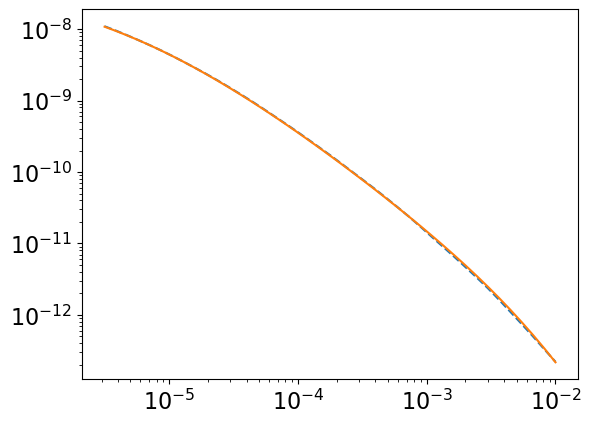

In [18]:
plt.loglog(times_ch1, -d_off[:times_ch1.size], '--')
plt.loglog(times_ch1, -dpred_1d[:times_ch1.size])

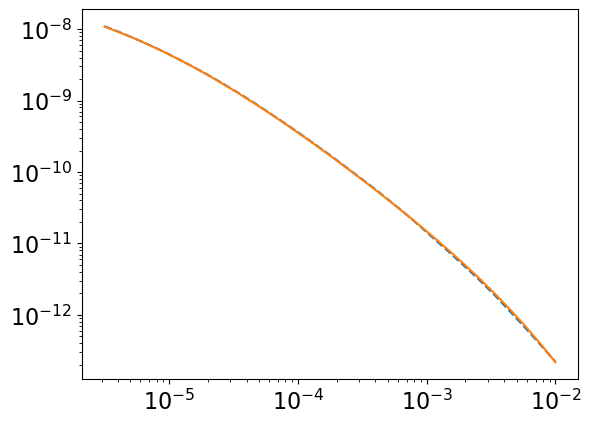

In [19]:
plt.loglog(times_ch2, -d_off[times_ch1.size:], '--')
plt.loglog(times_ch2, -dpred_1d[times_ch1.size:])

In [20]:
print ('rmse = {:.2e}'.format(np.sqrt((((d_off-dpred_1d)/d_off)**2).sum()/ d_off.size))) 

rmse = 2.86e-02
